[196, 196]


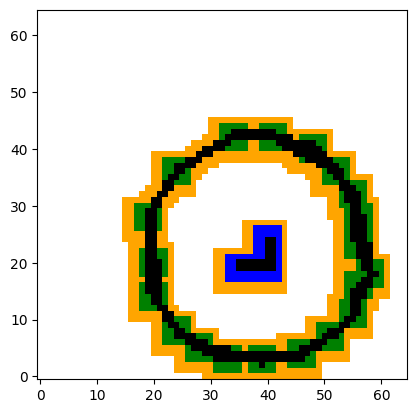

[33, 31]


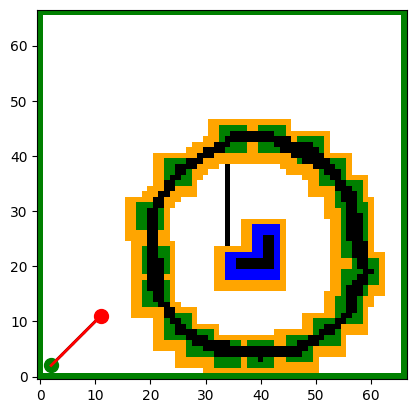

In [10]:
import numpy as np
from discretizer import Discretizer
from a_star import A_Star
import matplotlib.pyplot as plt
import ev3_dc as ev3
from matplotlib import colors

trajectory = []
path = []

class Main():
    def __init__(self) -> None:
        global trajectory
        global path

        landmarks = np.loadtxt("landmarks.csv", delimiter=",")

        size_x = int((max(np.abs(landmarks[:,0])))+10)
        size_y = int((max(np.abs(landmarks[:,1])))+10)
        world_coords=[max(size_x, size_y)*2, max(size_x, size_y)*2]
        print(world_coords)
        discretizer = Discretizer(landmarks, grid_size=3, world_coords=world_coords)
        discretizer.createMap(surrounding=6)
        
        cmap = colors.ListedColormap(['white', 'green', 'red', 'blue', 'black', 'orange', 'brown', 'pink'])
        plt.figure('Shortest path')
        plt.imshow( discretizer.world_map.transpose(1,0), origin="lower", cmap=cmap, vmin=0, vmax=7)
        plt.show()


        middle_point = np.array([int(world_coords[0]/2), int(world_coords[1]/2)])
        current_pos = list(np.array([1,1]) + ((np.array([0,0]) + middle_point)/3).astype(int))
        end = [current_pos[0], current_pos[1]-4]
        separating_middle = [current_pos[0], current_pos[1]-2]
        print(separating_middle)
        separaing_line = []

        i = 0
        while True:
            new_point = [separating_middle[0], separating_middle[1]-i]
            if discretizer.world_map[new_point[0],new_point[1]] == 5:
                break

            separaing_line.append(new_point)
            discretizer.world_map[new_point[0],new_point[1]] = 4
            i +=1

        i = 0
        while True:
            new_point = [separating_middle[0], separating_middle[1]+i]
            if discretizer.world_map[new_point[0],new_point[1]] == 5:
                break
            
            separaing_line.append(new_point)
            discretizer.world_map[new_point[0],new_point[1]] = 4
            i +=1
         

        a_star = A_Star([1, 1], [10,10], discretizer.world_map.transpose(1,0))
        path = a_star.find_path()
        d=a_star.d[1:world_coords[0]+1,1:world_coords[1]+1]
        trajectory = a_star.plan_trajectory(5)

        # plot shortest path
        #  0 = background / 1,2,3 = Markers / 4 = border / 5 = padding / 6 = start/finish / discs = 7 /
        cmap = colors.ListedColormap(['white', 'green', 'red', 'blue', 'black', 'orange', 'brown', 'pink'])
        plt.figure('Shortest path')
        plt.imshow(a_star.world_map + discretizer.mask.transpose(1,0), origin="lower", cmap=cmap, vmin=0, vmax=7)
        plt.plot(path[1],path[0], color="black", lw=2)
        plt.plot(a_star.start[1]+1,a_star.start[0]+1,'g.',markersize=20)
        plt.plot(a_star.goal[1]+1,a_star.goal[0]+1,'r.',markersize=20)


        for move in trajectory:
            plt.plot([move[0][1], move[1][1]], [move[0][0], move[1][0]], color="red", lw=2)

        plt.show()

        # self.drivePath(trajectory)

    def drivePath(self, trajectory):
        try:
            vehicle = ev3.TwoWheelVehicle (
                0.0280,
                0.1392, 
                protocol=ev3.USB
            ) 
            print("Start driving!")
            for move in trajectory:
                print(f"drive with {np.degrees(move[3])}")
                vehicle.drive_turn(np.degrees(move[3]), 0.0).start(thread=False)
                print(f"drive straight for {move[2]}cm")
                vehicle.drive_straight(move[2]).start(thread=False)

        except Exception as e:
                    print(e)
        vehicle.stop()
	
if __name__ == '__main__':
    main = Main()


drive_track
world coords
[340, 340]
created
discretized
[86 99]
[ 86 121]
path created
starting plot
saving


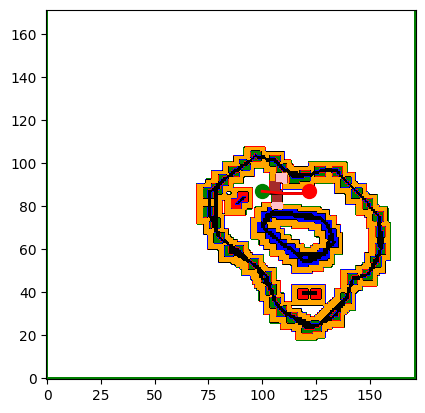

[[[87, 100], [86, 110], 0.1004987562112089, 1.6704649792860586], [[86, 110], [86, 121], 0.11, -0.09966865249116208]]


In [26]:
def drive_track(vehicle,landmarks):
    print('drive_track')
    grid_size = 2
    size_x = int((max(landmarks[:,0])-min(landmarks[:,0]))+10)
    size_y = int((max(landmarks[:,1])-min(landmarks[:,1]))+10)
    world_coords=[max(size_x, size_y)*2, max(size_x, size_y)*2]
    print('world coords')
    print(world_coords)
    discretizer = Discretizer(landmarks, grid_size=grid_size, world_coords=world_coords)
    print('created')
    discretizer.createMap(surrounding=6)
    print('discretized')
    middle_point = np.array([int(world_coords[0]/2), int(world_coords[1]/2)])
    start = np.array([1,1]) + ((np.array([0,27]) + middle_point)/grid_size).astype(int)
    end = np.array([1,1]) + ((np.array([0,70]) + middle_point)/grid_size).astype(int)
    print(start)
    print(end)
    a_star = A_Star(list(start), list(end), discretizer.world_map.transpose(1,0))
    path = a_star.find_path()
    print('path created')
    trajectory = a_star.plan_trajectory(3)

    print('starting plot')
    cmap = colors.ListedColormap(['white', 'green', 'red', 'blue', 'black', 'orange', 'brown', 'pink'])
    plt.figure('Shortest path')
    plt.imshow(a_star.world_map + discretizer.mask.transpose(1,0), origin="lower", cmap=cmap, vmin=0, vmax=7)
    plt.plot(path[1],path[0], color="black", lw=2)
    plt.plot(a_star.start[1]+1,a_star.start[0]+1,'g.',markersize=20)
    plt.plot(a_star.goal[1]+1,a_star.goal[0]+1,'r.',markersize=20)

    print('saving')
    plt.savefig('initial_map.png')

    for move in trajectory:
        plt.plot([move[0][1], move[1][1]], [move[0][0], move[1][0]], color="red", lw=2)

    plt.show()
    print(trajectory)

landmarks = np.loadtxt("landmarks.csv", delimiter=",")
drive_track(None, landmarks)

In [7]:
import numpy as np
from discretizer import Discretizer
from a_star import A_Star
import matplotlib.pyplot as plt
import ev3_dc as ev3
from matplotlib import colors

world_coords=[300,300]
landmarks = np.loadtxt("landmarks.csv", delimiter=",")
discretizer = Discretizer(landmarks, world_coords=world_coords)
discretizer.createMap(surrounding=12)
bin_map = np.where(discretizer.world_map >= 1, 1,0)
np.unique(bin_map)

array([0, 1])

In [2]:
import numpy as np
print(np.degrees(2.58))
print(np.degrees(-5.11))
print(np.degrees(0.93))
print(np.degrees(0.24))

147.82311114375239
-292.78143331185066
53.285074947166564
13.750987083139757


In [1]:
trajectory = [[[87, 100], [86, 110], 0.1004987562112089, 1.6704649792860586], 
            [[86, 110], [86, 121], 0.11, -0.09966865249116208]]

In [2]:
import ev3_dc as ev3
import numpy as np

try:
    vehicle = ev3.TwoWheelVehicle (
        0.02968,
        0.12832, 
        protocol=ev3.USB
    ) 
    print("Start driving!")
    speed = 20
    trajectory[0][3] =  trajectory[0][3] - (np.pi/2)
    for move in trajectory:
        if np.degrees(move[3]) > 1 or np.degrees(move[3]) < -1 :
            print(f"turn with {-(np.degrees(move[3]))} degrees")
            vehicle.drive_turn(-(np.degrees(move[3])), 0.0).start(thread=False)
        if move[2]>0.01:
            print(f"drive straight for {move[2]}cm")
            vehicle.drive_straight(move[2] * 2, speed=speed).start(thread=False)

except Exception as e:
    print(e)

vehicle.stop()


Start driving!
turn with 84.28940686250036 degrees
drive straight for 0.1004987562112089cm
turn with 5.710593137499646 degrees
drive straight for 0.11cm


In [4]:
trajectory

[[[151, 151], [195, 151], 0.44, 0.01],
 [[195, 151], [229, 162], 0.35735136770411274, 0.3029012278803845],
 [[229, 162], [249, 186], 0.31240998703626616, 0.563156822717809],
 [[249, 186], [270, 210], 0.3189043743820395, -0.024091723424921274]]

In [1]:
import ev3_dc as ev3
import numpy as np

with ev3.TwoWheelVehicle(
    0.0224,  # radius_wheel_measured
    0.1116,   # tread
    protocol=ev3.USB,
) as my_vehicle:
    my_vehicle.drive_turn(3600, 0.0).start(thread=False)

In [2]:
import numpy as np

not_visited = {}
not_visited[(0,0)] = "test"
not_visited

{(0, 0): 'test'}

In [12]:
d=np.full((400,500), np.inf)
for i, row in enumerate(d):
    for j, column in enumerate(row):
        not_visited[(i,j)] = np.inf

In [6]:
import numpy as np
test = np.array([[1,2,0],
                [2,3,0]])
min(test[:,0])


1

In [7]:
test = [1,2,3,4,5]
print(test.pop(0))
test

1


[2, 3, 4, 5]